In [15]:
#!pip uninstall huetracer -y
#!pip install huetracer
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import pandas as pd
import huetracer
import scvi
import gc
import math

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

scvi.settings.seed = 0
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
pd.set_option('display.max_columns', None)


Seed set to 0


In [2]:
### parameters to be input
SAMPLE_NAME = 'Colon'
lib_id = 'Visium_HD_Human_Colon_Cancer' # list(sp_adata.uns['spatial'].keys())[0]

path = os.path.expanduser("~")+"/Desktop/space/colon"
save_path_for_today = os.path.expanduser("~")+"/tmp/outputs/250610_" + SAMPLE_NAME
source_image_path = "../VisiumHD/image/microscope_image/Visium_HD_Human_Colon_Cancer_tissue_image.btf"
output_tiff_path = os.path.expanduser("~")+"/tmp/outputs/250610_" + SAMPLE_NAME + "Visium_HD_Human_Colon_Cancer_tissue_image_full_res.tiff"
expression_path = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_002um"
### optional 8 um binned dataset
expression_path_8um = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_008um"

# single cell transcriptome dataset (10X Chromium)
sc_adata_colon_dir = 'sc/filtered_feature_bc_matrix'

# area to be analyzed
# ## GCTB spatial G1, FFPE9
mask_small_x1, mask_small_x2, mask_small_y1, mask_small_y2 = 1250, 1550, 50, 350
mask_large_x1, mask_large_x2, mask_large_y1, mask_large_y2 = 250, 1750, 50, 1550

# List of target gene names
target_genes = [
    'TNFSF11', 'LIF', 'TNFRSF11A', 'LIFR',
    'CTSK', 'CTSB', 'LMNB1', 'MEGF10',
    'MMP9', 'MMP13', 'SPP1', 'GRN',
    'NOTCH3', 'SDC2', 'TIMP1', 'SPARC',
    'ACP5'
    # Add more genes here if needed
]


# setting for filenames
label_image_filename = "he_labels_image.pdf"
h5ad_filename = SAMPLE_NAME + "_b2c.h5ad"
h5ad_full_filename = SAMPLE_NAME + "_2um.h5ad"
h5ad_predicted_full_filename = SAMPLE_NAME + "_nucleus_predicted.h5ad"
h5ad_sc_filtered_full_filename = SAMPLE_NAME + "_single_cell_filtered.h5ad"
h5ad_sc_microenvironment_full_filename = SAMPLE_NAME + "_single_cell_microenvironment.h5ad"
save_spatial_plot_path = os.path.join(save_path_for_today, "cropped_spatial_plot.svg")
save_svg_path = os.path.join(save_path_for_today, "spatial_salvage_labels.svg")
h5ad_save_path = os.path.join(save_path_for_today, h5ad_filename)
h5ad_full_save_path = os.path.join(save_path_for_today, h5ad_full_filename)
h5ad_predicted_full_save_path = os.path.join(save_path_for_today, h5ad_predicted_full_filename)
h5ad_sc_filtered_full_save_path = os.path.join(save_path_for_today, h5ad_sc_filtered_full_filename)
h5ad_microenvironment_full_save_path = os.path.join(save_path_for_today, h5ad_sc_microenvironment_full_filename)

os.chdir(path)
os.makedirs(save_path_for_today, exist_ok=True)


# Single cell transcriptome annotation

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_colon_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=500)
sc.pp.filter_genes(sc_adata, min_cells=50)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 2000)
sc.pp.filter_cells(sc_adata, max_counts = 20000)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 5]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

sc_adata1 = sc_adata.copy()

In [5]:
common_genes = set(sc_adata1.var_names)# & set(sc_adata2.var_names) & set(sc_adata3.var_names) & set(sc_adata5.var_names) & set(sc_adata6.var_names) & set(sc_adata7.var_names) & set(sc_adata8.var_names)
sc_adata1 = sc_adata1[:, list(common_genes)]
# sc_adata2 = sc_adata2[:, list(common_genes)]
# sc_adata3 = sc_adata3[:, list(common_genes)]
# sc_adata4 = sc_adata4[:, list(common_genes)]
# sc_adata5 = sc_adata5[:, list(common_genes)]
# sc_adata6 = sc_adata6[:, list(common_genes)]
# sc_adata7 = sc_adata7[:, list(common_genes)]
# sc_adata8 = sc_adata8[:, list(common_genes)]
sc_adatas = [sc_adata1]#, sc_adata2, sc_adata3, sc_adata4, sc_adata5, sc_adata6, sc_adata7, sc_adata8]
#sc_adatas = [sc_adata1, sc_adata2, sc_adata3, sc_adata5, sc_adata6, sc_adata7, sc_adata8]
sc_adata_merged = sc_adatas[0]#.concatenate(sc_adatas[1:], batch_key='batch')
del sc_adata1
gc.collect()
# save raw count data
sc_adata_merged.layers["counts"] = sc_adata_merged.X.copy()
sc_adata_merged.raw = sc_adata_merged

/var/folders/4d/y2tgzy191n37wnz840jkr6980000gp/T/ipykernel_57243/2230003032.py:16: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  sc_adata_merged.layers["counts"] = sc_adata_merged.X.copy()


In [ ]:
np.random.seed(SEED)
random.seed(SEED)
sc_adata_merged.X = sc_adata_merged.raw.X.copy()
sc_adata_merged.var = sc_adata_merged.raw.var.copy()
sc.pp.normalize_total(sc_adata_merged, target_sum=1e4)
sc.pp.log1p(sc_adata_merged)
# sc.pp.highly_variable_genes(sc_adata_merged, flavor = 'seurat_v3', n_top_genes=2000,
#                             layer = "counts", batch_key="batch", subset = False)
sc.pp.highly_variable_genes(sc_adata_merged, flavor = 'seurat_v3', n_top_genes=2000,
                            layer = "counts", subset = False)
hvg_genes = sc_adata_merged.var_names[sc_adata_merged.var['highly_variable']].tolist()
sc.tl.pca(sc_adata_merged, svd_solver='arpack',use_highly_variable=True, n_comps=30, random_state=SEED)
# ho = run_harmony(sc_adata_merged.obsm['X_pca'], sc_adata_merged.obs, 'batch',random_state=SEED)
# sc_adata_merged.obsm['X_pca_harmony'] = ho.Z_corr.T
# sc.pp.neighbors(sc_adata_merged, use_rep='X_pca_harmony', random_state=SEED)
sc.pp.neighbors(sc_adata_merged, use_rep='X_pca', random_state=SEED)
sc.tl.umap(sc_adata_merged, random_state=SEED)
sc.tl.leiden(sc_adata_merged, resolution=1, key_added='leiden', random_state=SEED)
sc_adata_merged.obs['leiden'] = sc_adata_merged.obs['leiden'].apply(lambda x: f"C{x}")
sc.pl.pca(sc_adata_merged, color='total_counts', components=['1,2', '2,3', '1,3'])
sc.pl.pca_variance_ratio(sc_adata_merged, log=True)
sc_adata_merged.var.sort_values("variances_norm",ascending=False).head(10)
#sc.pl.umap(sc_adata_merged, color=['leiden', 'total_counts', 'batch'],use_raw=False)
sc.pl.umap(sc_adata_merged, color=['leiden', 'total_counts'],use_raw=False)
sc.pl.umap(sc_adata_merged, color=['EGFR', 'COL1A1', 'CTSK'],use_raw=False)


In [ ]:
sc.tl.dendrogram(sc_adata_merged, groupby='leiden')
sc.tl.rank_genes_groups(sc_adata_merged, 'leiden', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(sc_adata_merged, n_genes=25, sharey=False)

genes_df = pd.DataFrame(sc_adata_merged.uns['rank_genes_groups']['names'])
genes = genes_df.head(3).values.tolist()  # top 3 genes
genes = [item for sublist in genes for item in sublist]
genes = list(dict.fromkeys(genes))
genes = [str(g) for g in genes]
for i in range(0, len(genes), 4):
    subset_genes = [str(g) for g in genes[i:i + 4]]
    sc.pl.violin(
        sc_adata_merged,
        subset_genes,
        groupby='leiden',
        use_raw=False
    )

In [ ]:
gene_array = np.array(sc_adata_merged.uns['rank_genes_groups']['names'].tolist())
gene_list = np.unique(gene_array[0:4,:].flatten())
sc.pl.umap(sc_adata_merged, color=gene_list, use_raw=False)

In [16]:
pd.DataFrame(sc_adata_merged.uns['rank_genes_groups']['names']).head(20)

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31
0,JCHAIN,IGHG1,CEACAM6,IGHA1,COL1A1,CTSB,DCN,MYL9,PIGR,IGKC,GPX2,COL3A1,IGFBP7,FCGBP,COL6A1,TRAC,JCHAIN,PECAM1,LCP1,HIST1H1C,CXCL14,JCHAIN,STAB1,IGLC1,CEACAM6,IGHM,IFI30,IGLC1,L1CAM,IGHM,IGLC1,CXCL13
1,IGHA2,XBP1,PYGB,JCHAIN,COL1A2,PSAP,TNXB,MYH11,LGALS4,XBP1,S100P,COL1A1,EPAS1,TSPAN1,PDLIM7,TRBC2,IGKC,CDH5,SPI1,HIST1H1B,A2M,IGHA2,CD163,JCHAIN,CEACAM5,MZB1,LYZ,IGHA1,CLU,JCHAIN,IGHG1,CD37
2,TXNDC5,MZB1,CD24,TXNDC5,COL3A1,CTSZ,MGP,TAGLN,PHGR1,IGHG1,KRT8,COL1A2,COL4A1,PIGR,PRUNE2,ETS1,TXNDC5,ENG,LYZ,LSP1,ADAMDEC1,TXNDC5,C1QA,TXNDC5,MUC12,JCHAIN,SAT1,JCHAIN,NCAM1,TXNDC5,XBP1,MS4A1
3,UBE2J1,TENT5C,CEACAM5,MZB1,COL5A1,C1QC,GSN,MYLK,TSPAN8,MZB1,TMSB10,SPARC,COL4A2,PHGR1,SMTN,CD2,UBE2J1,EGFL7,CD74,POU2AF1,LTBP4,UBE2J1,RNASE1,SSR4,CD24,TXNDC5,FTL,TXNDC5,DKK3,IGHA2,MZB1,FCGBP
4,HERPUD1,DERL3,MUC12,DERL3,AEBP1,C1QB,FBLN1,DES,FXYD3,DERL3,EPCAM,LUM,COL18A1,CLDN7,COL6A2,CORO1A,SSR4,CD93,SRGN,MYBL2,C1S,CD79A,FCGRT,UBE2J1,PYGB,DERL3,SRGN,SSR4,CRYAB,UBE2J1,DERL3,CLCA1
5,TENT5C,IGKC,ST14,SSR4,BGN,CD68,OGN,TPM2,AGR2,TENT5C,CEACAM5,MMP2,A2M,FXYD3,SVIL,EVL,HERPUD1,VWF,LAPTM5,RAC2,EMILIN1,TENT5C,C1QC,SEC11C,EPCAM,SEC11C,SPI1,UBE2J1,HAND2,IGKC,SSR4,FDCSP
6,SSR4,IGHG3,EPCAM,SEC11C,COL6A3,C1QA,LTBP4,CNN1,EPCAM,SSR4,CD24,COL6A3,NOTCH3,LGALS4,TPM1,CD3E,TENT5C,S1PR1,FGL2,MKI67,MFAP4,POU2AF1,CSF1R,TENT5C,MT-CO2,PIM2,FCER1G,SEC11C,CD9,SEC11C,SEL1L3,IGHM
7,SEC11C,SSR4,GPRC5A,UBE2J1,LUM,IFI30,C1R,ACTG2,MUC12,POU2AF1,S100A6,C1S,MCAM,EPCAM,FLNA,CD3D,IGHA2,ECSCR,ITGB2,HIST1H1D,EDIL3,GPR15,MRC1,HERPUD1,MT-ATP6,HERPUD1,GLUL,MZB1,ANK2,HERPUD1,ST6GAL1,CR2
8,IGKC,ST6GAL1,RNF43,HERPUD1,COL5A2,GRN,LRP1,CSRP1,ITM2C,SEC11C,LCN2,COL5A1,SPARC,KRT8,TNS1,LCP1,SEC11C,EPAS1,SAMHD1,ATP2A3,TMEM176B,HERPUD1,SELENOP,DERL3,KRT8,SSR4,LAPTM5,HERPUD1,S100B,TENT5C,IGHG3,CXCR4
9,POU2AF1,SEL1L3,ELF3,TENT5C,THBS2,CD74,LUM,SYNPO2,KRT8,PIM2,CEACAM6,IGFBP7,RGS5,MUC13,LIMS2,IKZF1,PIM2,TM4SF1,MPEG1,CORO1A,ABCA8,SEC11C,F13A1,FKBP11,MYC,POU2AF1,CD163,DERL3,NRXN1,PIM2,FKBP11,IGHD


In [ ]:
sc.pl.rank_genes_groups_heatmap(sc_adata_merged, use_raw=False)
sc.pl.rank_genes_groups_heatmap(sc_adata_merged, show_gene_labels=True, use_raw=False)


In [ ]:
# UMAP座標
umap_data = sc_adata_merged.obsm['X_umap']


# クラスタリストをソート（C1, C2, ..., C23 順）
clusters = sorted(
    sc_adata_merged.obs['leiden'].unique().tolist(),
    key=lambda x: int(x[1:])
)

# 横6列、必要な行数を計算
n_cols = 6
n_rows = math.ceil(len(clusters) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

for idx, cluster in enumerate(clusters):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    is_highlight = sc_adata_merged.obs['leiden'] == cluster
    
    # 灰色（他クラスタ）
    ax.scatter(
        umap_data[~is_highlight, 0],
        umap_data[~is_highlight, 1],
        color='lightgrey',
        s=10,
        alpha=0.3
    )
    
    # 赤（対象クラスタ）
    ax.scatter(
        umap_data[is_highlight, 0],
        umap_data[is_highlight, 1],
        color='red',
        s=10,
        alpha=0.6
    )
    
    ax.set_title(f"{cluster}")
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

# 余った空白プロットを消す
for j in range(len(clusters), n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Manual single cell transcriptome cluster annotation
annotation_dict = {
    'C0':  'Plasma_B',
    'C1':  'Plasma_B',
    'C2':  'Epithelial_Tumor',
    'C3':  'Plasma_B',
    'C4':  'CAF_Fibroblast',  # COL1A1, COL1A2, COL3A1 - 細胞外マトリックス産生
    'C5':  'Macrophage',  # CTSB, PSAP, CTSZ, C1QC - リソソーム酵素とマクロファージマーカー
    'C6':  'CAF_Myofibroblast',  # DCN, TNXB, MGP - 細胞外マトリックス調節
    'C7':  'Smooth_Muscle_Cell',  # MYL9, MYH11, TAGLN, MYLK - 平滑筋特異的マーカー
    'C8':  'Epithelial_Secretory',  # PIGR, LGALS4, PHGR1 - 分泌機能を持つ上皮細胞
    'C9':  'Plasma_B',
    'C10': 'Epithelial_Tumor',  # GPX2, S100P, KRT8 - 腫瘍上皮細胞
    'C11': 'CAF_ECM_Rich',  # COL3A1, COL1A1, COL1A2, SPARC - ECM豊富なCAF
    'C12': 'Pericyte_Vascular',  # IGFBP7, EPAS1, COL4A1, COL4A2 - 血管周皮細胞
    'C13': 'Epithelial_Goblet',  # FCGBP, TSPAN1, PIGR - 杯細胞
    'C14': 'Myofibroblast',  # COL6A1, PDLIM7, SMTN - 筋線維芽細胞
    'C15': 'T_Cell',  # TRAC, TRBC2, CD2, CD3E, CD3D - T細胞受容体複合体
    'C16': 'Plasma_B',
    'C17': 'Endothelial',  # PECAM1, CDH5, EGFL7, ECSCR - 内皮細胞特異的
    'C18': 'Myeloid_Monocyte',  # LCP1, SPI1, LYZ, CD74 - 単球系骨髄細胞
    'C19': 'Proliferating_Cell',  # HIST1H1C, HIST1H1B, HIST1H1D, MKI67 - 増殖細胞
    'C20': 'CAF_Inflammatory',  # CXCL14, A2M, ADAMDEC1 - 炎症性CAF
    'C21': 'Plasma_B',
    'C22': 'Macrophage_M2',  # STAB1, CD163, C1QA, CSF1R, MRC1 - M2マクロファージ
    'C23': 'Plasma_B',
    'C24': 'Epithelial_Tumor_CEACAM',  # CEACAM6, CEACAM5, MUC12 - CEACAM高発現腫瘍上皮
    'C25': 'Plasma_B',
    'C26': 'Myeloid_Antigen_Presenting',  # IFI30, LYZ, SPI1, FCER1G - 抗原提示細胞
    'C27': 'Plasma_B',
    'C28': 'Epithelial_Mesenchymal_Transition',  # L1CAM, NCAM1, DKK3, CRYAB - EMT関連
    'C29': 'Plasma_B',
    'C30': 'Plasma_B',
    'C31': 'B_Cell_Follicular',  # CXCL13, CD37, CR2, CXCR4, BANK1 - 濾胞性B細胞
}

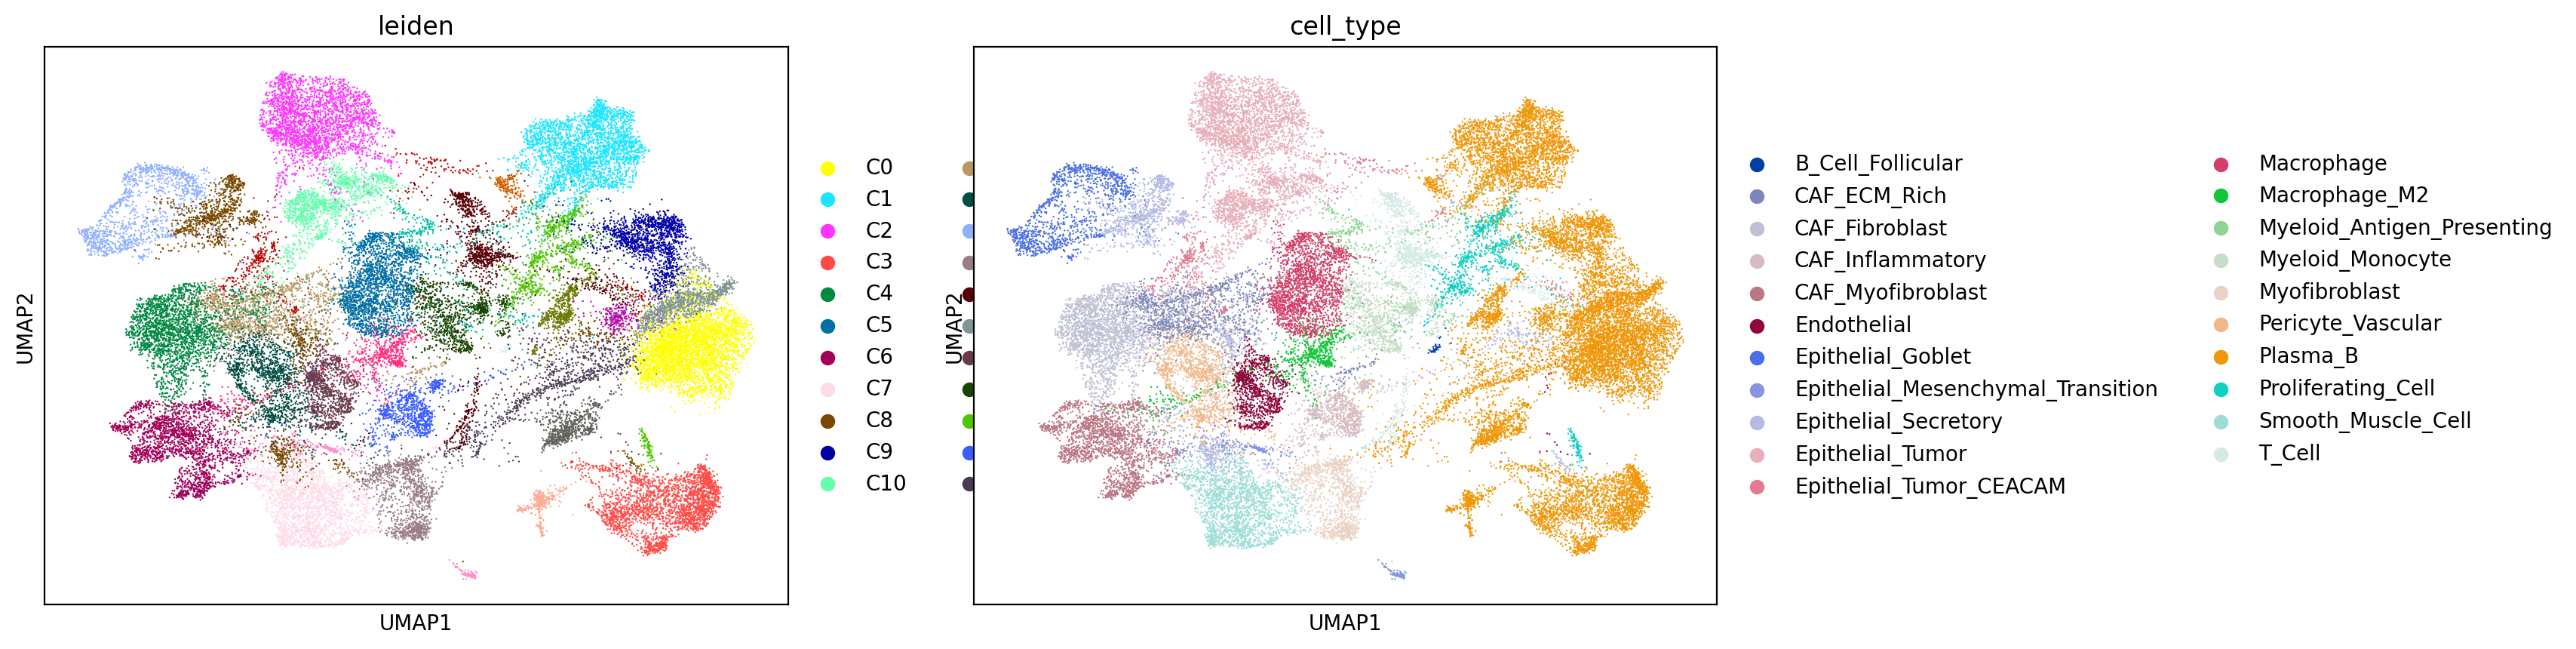

In [21]:
sc_adata_merged.obs['cell_type'] = [annotation_dict[clust] for clust in sc_adata_merged.obs['leiden']]
# Doublet以外の細胞だけ残す
filtered_sc_adata = sc_adata_merged[~sc_adata_merged.obs['cell_type'].isin(['Doublet', 'Other'])].copy()
sc.pl.umap(filtered_sc_adata, color=['leiden', 'cell_type'])
#filtered_sc_adata.obs['cell_type_annotation'] = filtered_sc_adata.obs['cell_type']
filtered_sc_adata.obs['cell_type_annotation'] = filtered_sc_adata.obs['leiden']
filtered_sc_adata.write_h5ad(h5ad_sc_filtered_full_save_path)

/Users/ikegami/.pyenv/versions/3.11.7/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/ikegami/.pyenv/versions/3.11.7/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/ikegami/.pyenv/versions/3.11.7/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:463

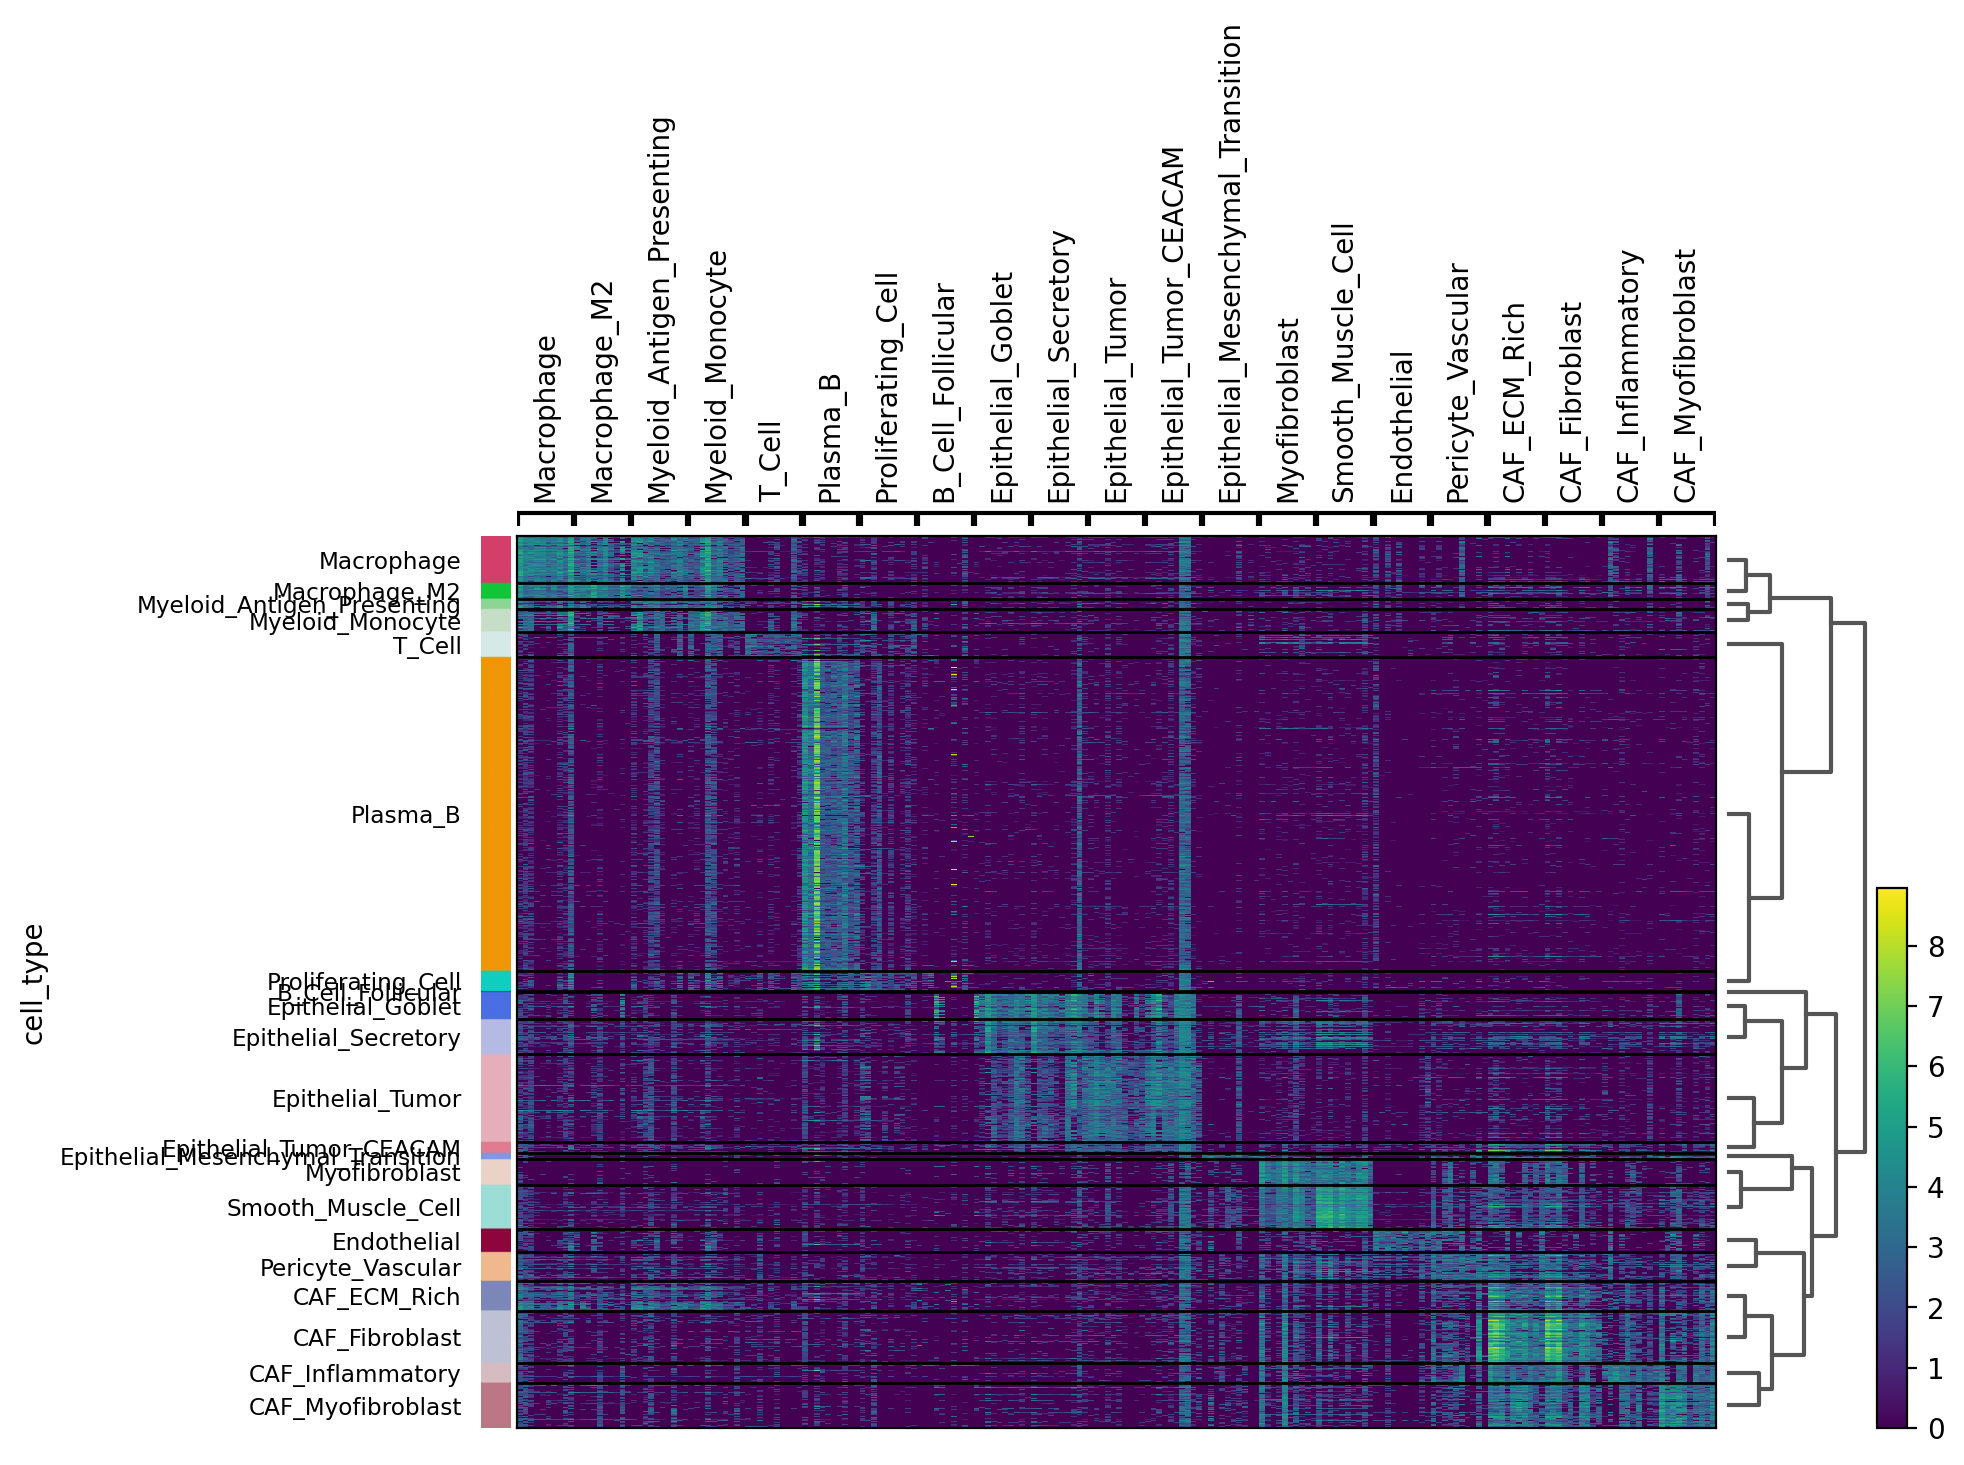

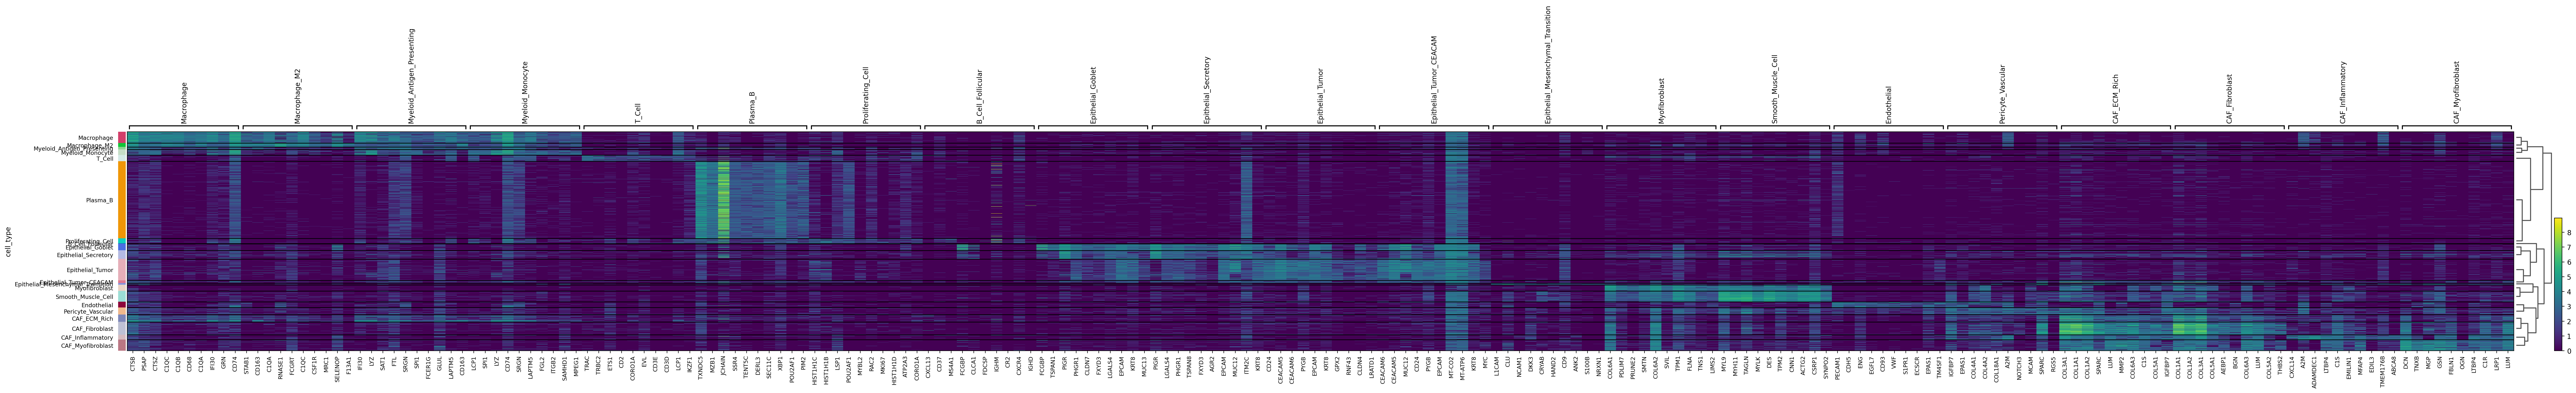

In [22]:
sc.tl.dendrogram(filtered_sc_adata, groupby='cell_type')
sc.tl.rank_genes_groups(filtered_sc_adata, 'cell_type', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups_heatmap(filtered_sc_adata, use_raw=False)
sc.pl.rank_genes_groups_heatmap(filtered_sc_adata, show_gene_labels=True, use_raw=False)
